# LOAD & CLEAN

In [1]:
import numpy as np
from scipy.stats import randint
import pandas as pd
import shap

import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.metrics import average_precision_score, mean_absolute_error, f1_score, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from hurdle_cleaning_functions import clean_data, combine_columns
from hurdle_feature_engineering_functions import add_increment_column, create_full_feature_pipeline

pd.set_option('display.max_rows', 300)

C:\Users\ravin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SVRM3_ewon_df = pd.read_feather('SVRM3_ewon_complete.feather')
SVRM4_ewon_df = pd.read_feather('SVRM4_ewon_complete.feather')

In [3]:
SVRM3_ewon_df_cleaned = clean_data(SVRM3_ewon_df)
SVRM4_ewon_df_cleaned = clean_data(SVRM4_ewon_df)

c:\Users\ravin\Downloads\predictive_maintenance_tsg\hurdle_cleaning_functions.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


821177 rows only have NaN entries (except Timestamps)
395 rows are duplicated on TimeStr
820690 rows retained. Data is cleaned


c:\Users\ravin\Downloads\predictive_maintenance_tsg\hurdle_cleaning_functions.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["Undef", "nan"], np.nan)


746060 rows only have NaN entries (except Timestamps)
1204 rows are duplicated on TimeStr
744742 rows retained. Data is cleaned


In [4]:
column_pairs_SVRM3 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].bgem"),
    ("dgem", "StangHistorie[1].dgem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]

column_pairs_SVRM4 = [
    ("BeginVerduningPosHor", "StangHistorie[1].BeginVerduningPosHor"),
    ("BeginVerdunningPos", "StangHistorie[1].BeginVerdunningPos"),
    ("EindVerduningPos", "StangHistorie[1].EindVerduningPos"),
    ("EindVerduningPosHor", "StangHistorie[1].EindVerduningPosHor"),
    ("Pos-UitloCor_2_trek24", "StangData.Pos-UitloCor_2_trek24"),
    ("Pos_inloCor_1_trek13", "StangData.Pos_inloCor_1_trek13"),
    ("Pos_inloCor_1_trek24", "StangData.Pos_inloCor_1_trek24"),
    ("Pos_inloCor_2_trek13", "StangData.Pos_inloCor_2_trek13"),
    ("Pos_uitloCor_1_trek13", "StangData.Pos_uitloCor_1_trek13"),
    ("Pos_uitloCor_1_trek24", "StangData.Pos_uitloCor_1_trek24"),
    ("Pos_uitloCor_2_trek13", "StangData.Pos_uitloCor_2_trek13"),
    ("Pos_inloCor_2_trek24", "StangData.Pos_inloCor_2_trek24"),
    ("bgem", "StangHistorie[1].b_gem"),
    ("dgem", "StangHistorie[1].d_gem"),
    ("Lengte_verduning", "StangHistorie[1].L_v")
]


for col1, col2 in column_pairs_SVRM3:
    SVRM3_ewon_df_cleaned = combine_columns(SVRM3_ewon_df_cleaned, col2, col1)

for col1, col2 in column_pairs_SVRM4:
    SVRM4_ewon_df_cleaned = combine_columns(SVRM4_ewon_df_cleaned, col2, col1)

In [5]:
df_3 = SVRM3_ewon_df_cleaned.copy()
df_4 = SVRM4_ewon_df_cleaned.copy()

df_3 = add_increment_column(df_3, "afgekeurd")

# Feature Engineering

In [6]:
import pandas as pd

features = df_3.columns[df_3.columns.str.contains("StangHistorie")]
rejected_mask = df_3["afgekeurd_inc"] > 0

rows = []

for param in features:
    s = df_3[param]

    std_30 = s.rolling(30).std()
    std_15 = s.rolling(15).std()

    normal_30 = std_30[~rejected_mask]
    reject_30 = std_30[rejected_mask]

    normal_15 = std_15[~rejected_mask]
    reject_15 = std_15[rejected_mask]

    rows.extend([
        ("Std 30s (normal)", param, normal_30.mean()),
        ("Std 30s (normal ±)", param, normal_30.std()),
        ("Std 30s (rejected)", param, reject_30.mean()),
        ("Std 30s (rejected ±)", param, reject_30.std()),
        ("Volatility ratio 30s", param, reject_30.mean() / (normal_30.mean() + 15e-6)),

        ("Std 15s (normal)", param, normal_15.mean()),
        ("Std 15s (normal ±)", param, normal_15.std()),
        ("Std 15s (rejected)", param, reject_15.mean()),
        ("Std 15s (rejected ±)", param, reject_15.std()),
        ("Volatility ratio 15s", param, reject_15.mean() / (normal_15.mean() + 15e-6)),
    ])

# Build final table
summary_df = (
    pd.DataFrame(rows, columns=["Metric", "Feature", "Value"])
    .pivot(index="Metric", columns="Feature", values="Value")
    .round(6)
)

summary_df
# This shows how volatile the raw features are when rejection happens.

Feature,StangHistorie[1].BeginVerduningPosHor,StangHistorie[1].BeginVerdunningPos,StangHistorie[1].EindVerduningPos,StangHistorie[1].EindVerduningPosHor,StangHistorie[1].L_v,StangHistorie[1].bgem,StangHistorie[1].dgem
Metric,,,,,,,
Std 15s (normal ±),1.588763,1.562667,1.386642,1.505952,3.753597,0.008871,0.008950
Std 15s (normal),0.074774,0.060969,0.076043,0.082203,0.198823,0.000636,0.000504
Std 15s (rejected ±),34.729071,33.345288,26.128941,27.227822,63.563266,0.218418,0.222717
Std 15s (rejected),22.224260,20.991350,13.723471,15.060049,34.171884,0.075247,0.076226
Std 30s (normal ±),1.930718,1.875748,1.668019,1.794993,4.217330,0.011702,0.011839
Std 30s (normal),0.097695,0.082812,0.096655,0.104306,0.245472,0.000757,0.000618
Std 30s (rejected ±),34.980236,34.761044,30.414428,31.373420,63.318005,0.272825,0.278288
Std 30s (rejected),27.266765,26.225570,19.547593,21.293487,40.987821,0.129356,0.131528
Volatility ratio 15s,297.159252,344.208393,180.433173,183.173199,171.857821,115.535317,146.862915


In [7]:
# Create features with 5-second windows
df_final = create_full_feature_pipeline(
    df_3,
    agg_seconds=30,
    volatility_windows=[4],
    timestamp_col="TimeInt"
)
    
df_final.columns = [
    str(col) if not isinstance(col, tuple) else f"{col[0]}_{col[1]}"
    for col in df_final.columns
]

df_final.columns = [c.replace("[","_").replace("]","_").replace("<","_").replace(">","_") 
                         for c in df_final.columns]


Aggregating raw data with 30s windows...
Original shape: (820690, 43)
Aggregated shape: (46380, 30)
Adding volatility features with window sizes: [4]...
Number of features added: 114


# Modeling Functions

In [8]:
def add_future_rejection_count(df, window=1):
    """
    Add target column for regression: rejection count in next horizon_windows.
    df must be aggregated per window already (e.g. 30s window).
    """
    df = df.copy()

    # Future count of rejections in the next horizon_windows
    df["rejected_count_next"] = (
        df_final['afgekeurd_inc_sum'].shift(-1).rolling(window, min_periods=1).sum()
    )

    # Drop last rows with unknown future
    df = df.dropna(subset=["rejected_count_next"])
    return df

def time_series_split(X, y, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test


def stratified_time_series_split(X, y, test_size=0.2):
    """
    Returns train and test indices for time-series data,
    ensuring both classes are represented in the test set.
    """
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    train_indices = []
    val_indices = []

    for cls in y.unique():
        cls_idx = y[y == cls].index.values
        split = int(len(cls_idx) * (1 - test_size))
        train_indices.extend(cls_idx[:split])
        val_indices.extend(cls_idx[split:])

    # Sort indices to preserve time order
    train_indices = sorted(train_indices)
    val_indices = sorted(val_indices)

    return train_indices, val_indices

def add_future_rejection_label(df):
    """
    Predict if a rejection will occur in the NEXT horizon_windows.
    """

    df = df.copy()
    df["rejected_next"] = (df["afgekeurd_inc_sum"].shift(-1) > 0).fillna(0).gt(0).astype(int)

    return df

# Hurdle Model

In [9]:
# Engineer target variables
cls_df = add_future_rejection_label(df_final)
reg_df = add_future_rejection_count(df_final, window=1)

# Drop columns that are not features
DROP_COLS = ["TimeInt_first", "TimeStr_first", "afgekeurd_inc_sum"]

# CLASSIFICATION MODEL
TARGET_CLS = "rejected_next"
X_cls = cls_df.drop(columns=[TARGET_CLS] + DROP_COLS, errors="ignore")
y_cls = cls_df[TARGET_CLS]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X_cls, y_cls)

# Handle class imbalance using scale pos weight
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / pos

clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

param_grid_clf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter tuning
search_cls = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid_clf,
    n_iter=50,
    scoring="average_precision",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Fit on train set
search_cls.fit(X_train, y_train)
print("Best classifier params:", search_cls.best_params_)

# Validation performance
val_pred = search_cls.predict_proba(X_val)[:, 1]
print("Validation AP:", average_precision_score(y_val, val_pred))


best_clf = XGBClassifier(
    **search_cls.best_params_,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Fit on train and val set
best_clf.fit(X_train_full, y_train_full)

# Final test evaluation
test_pred = best_clf.predict_proba(X_test)[:, 1]
print("Test AP:", average_precision_score(y_test, test_pred))


# REGRESSION MODEL
TARGET_REG = "rejected_count_next"
X_reg = reg_df.drop(columns=[TARGET_REG] + DROP_COLS, errors="ignore")
y_reg = reg_df[TARGET_REG]
X_train_r, y_train_r, X_val_r, y_val_r, X_test_r, y_test_r = time_series_split(X_reg, y_reg)

reg = XGBRegressor(
    objective="count:poisson",
    eval_metric="poisson-nloglik",
    random_state=42
)

param_grid_reg = {
    "n_estimators": [200, 300, 400],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

search_reg = RandomizedSearchCV(
    estimator=reg,
    param_distributions=param_grid_reg,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Fit on train set
search_reg.fit(X_train_r, y_train_r)
print("Best regression params:", search_reg.best_params_)
print("Best PR-AUC:", search_reg.best_score_)

# Validation performance
val_pred_r = search_reg.predict(X_val_r)
print("Validation MAE:", mean_absolute_error(y_val_r, val_pred_r))


best_reg = XGBRegressor(
    **search_reg.best_params_,
    objective="count:poisson",
    eval_metric="poisson-nloglik",
    random_state=42
)

X_train_full_r = pd.concat([X_train_r, X_val_r])
y_train_full_r = pd.concat([y_train_r, y_val_r])

# Fit on train and val set
best_reg.fit(X_train_full_r, y_train_full_r)

# Test evaluation
y_pred_test_r = best_reg.predict(X_test_r)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\ravin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best classifier params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Validation AP: 0.5827891462830537
Test AP: 0.4720529664547494
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best regression params: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best PR-AUC: -0.004994061028996936
Validation MAE: 0.007559186468897491


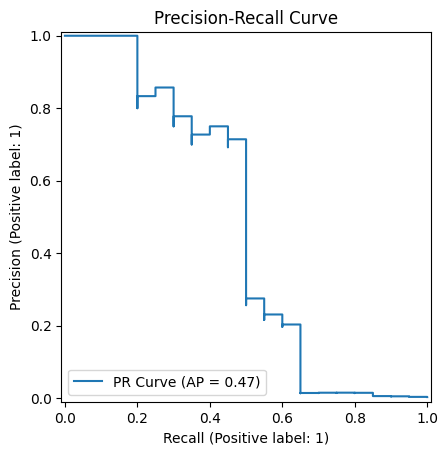

PR AUC: 0.4721


In [12]:
# Plot PR-AUC for classification model evaluation
display = PrecisionRecallDisplay.from_predictions(y_test, test_pred, name="PR Curve")
plt.title("Precision-Recall Curve")
plt.show()

# Calculate and print the PR AUC (Average Precision)
pr_auc = average_precision_score(y_test, test_pred)
print(f"PR AUC: {pr_auc:.4f}")

In [13]:
mask = y_test_r > 0
print("MAE for test set:", mean_absolute_error(y_test_r, y_pred_test_r))
print(f"MAE for rejection cases: {mean_absolute_error(y_test_r[mask], y_pred_test_r[mask])}")

MAE for test set: 0.013324522728219197
MAE for rejection cases: 4.5285869845625255


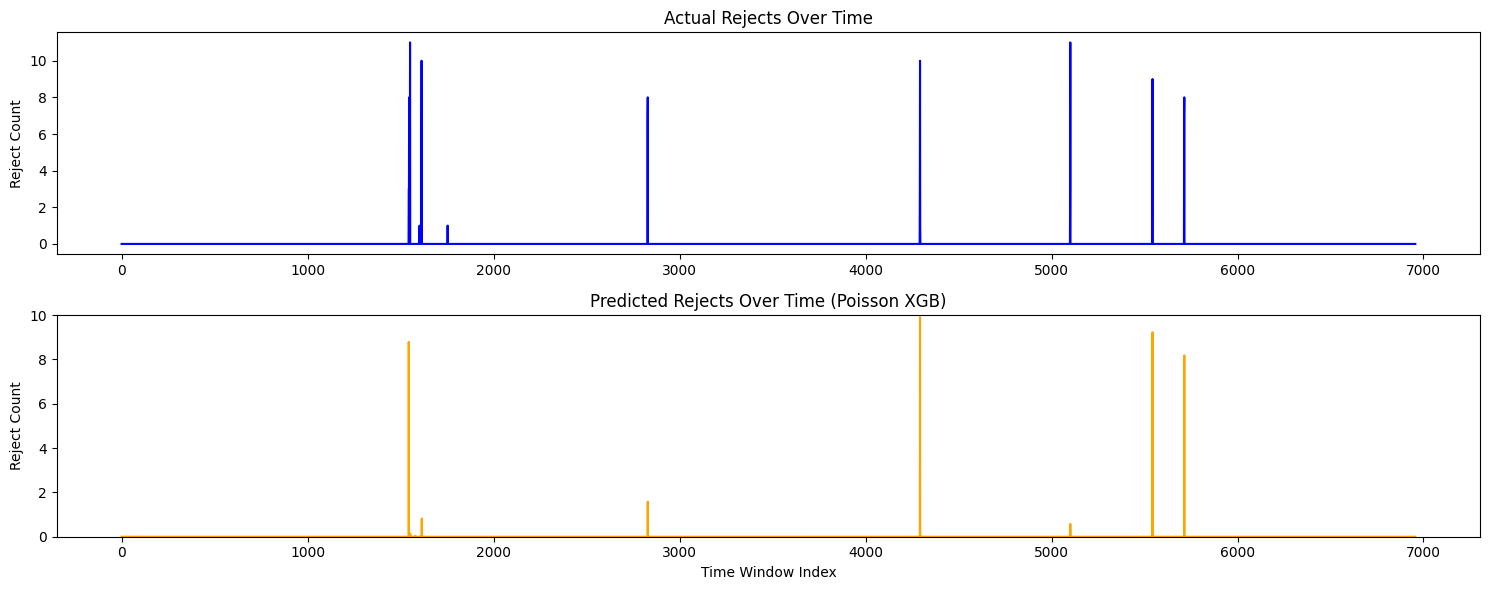

In [14]:
# Plot Actual vs Predicted Rejects over time for hurdle model evaluation
plt.figure(figsize=(15,6))

# Actual
plt.subplot(2, 1, 1)
plt.plot(y_test_r.values, color='blue')
plt.title('Actual Rejects Over Time')
plt.ylabel('Reject Count')

# Predicted
plt.subplot(2, 1, 2)
plt.plot(y_pred_test_r, color='orange')
plt.title('Predicted Rejects Over Time (Poisson XGB)')
plt.xlabel('Time Window Index')
plt.ylabel('Reject Count')
plt.ylim(0, 10)

plt.tight_layout()
plt.show()


# SHAP

<Figure size 1000x800 with 0 Axes>

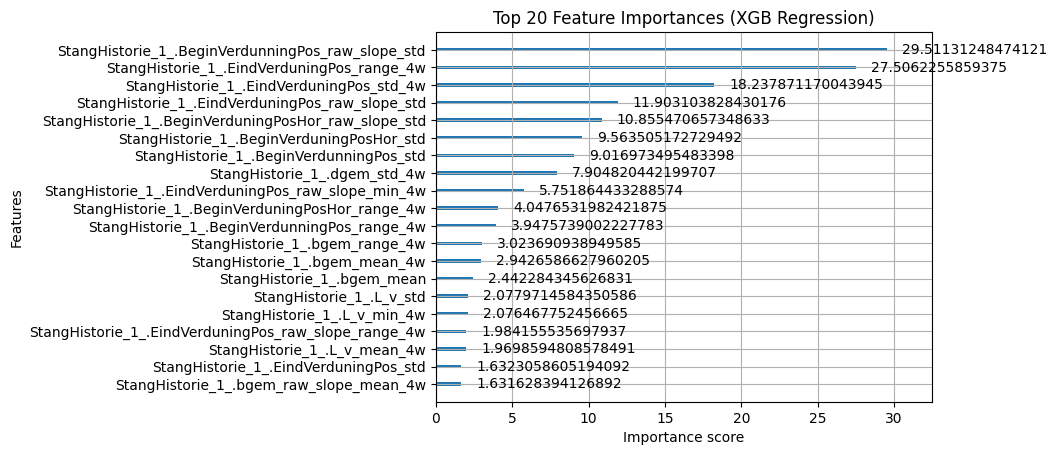

<Figure size 1000x800 with 0 Axes>

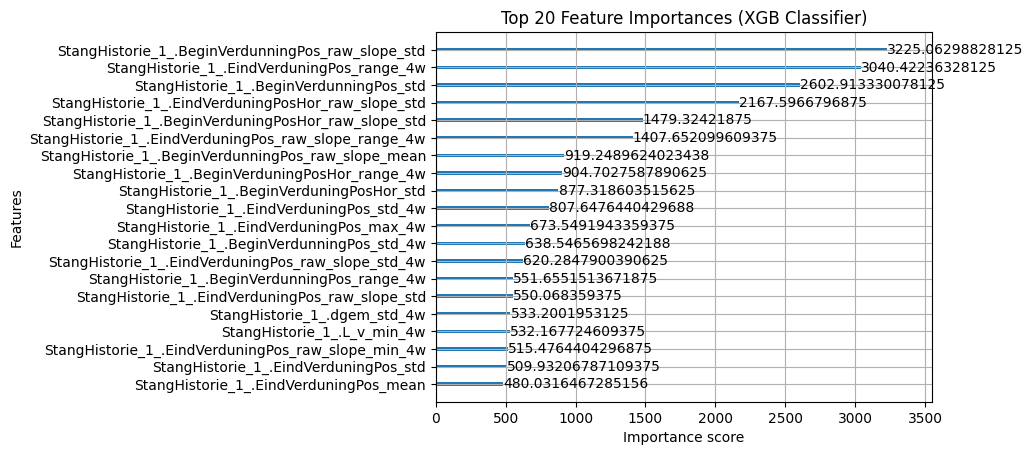

In [15]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# FEATURE IMPORTANCE FOR REGRESSION MODEL
plt.figure(figsize=(10, 8))
plot_importance(best_reg, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances (XGB Regression)")
plt.show()

# FEATURE IMPORTANCE FOR CLASSIFIER
plt.figure(figsize=(10, 8))
plot_importance(best_clf, importance_type='gain', max_num_features=20)
plt.title("Top 20 Feature Importances (XGB Classifier)")
plt.show()


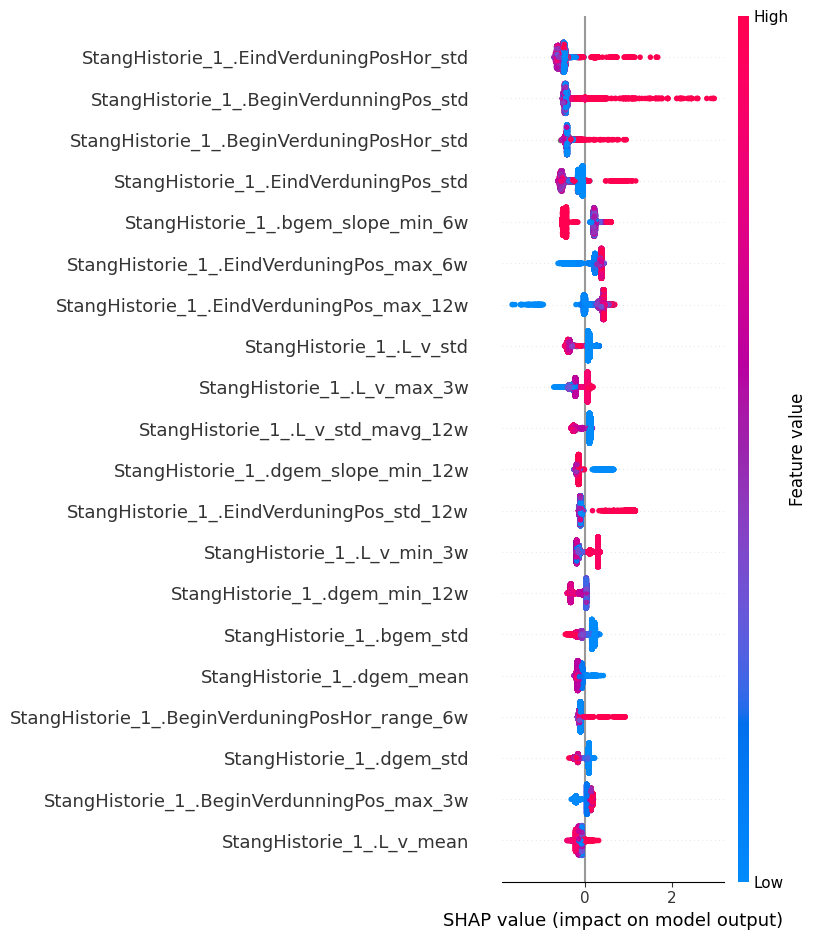

In [ ]:
# Create SHAP explainer
explainer_reg = shap.TreeExplainer(best_reg)

# Compute SHAP values on the test set
shap_values_reg = explainer_reg.shap_values(X_test_r)

# Summary plot (global importance)
shap.summary_plot(shap_values_reg, X_test_r, plot_type="dot")



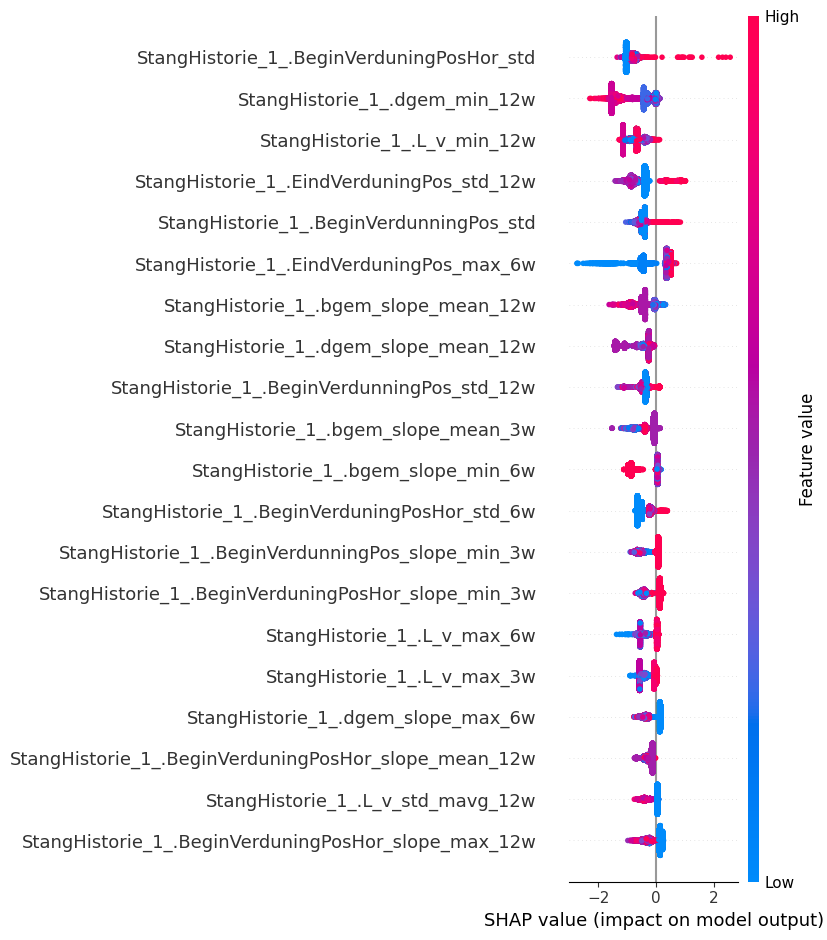

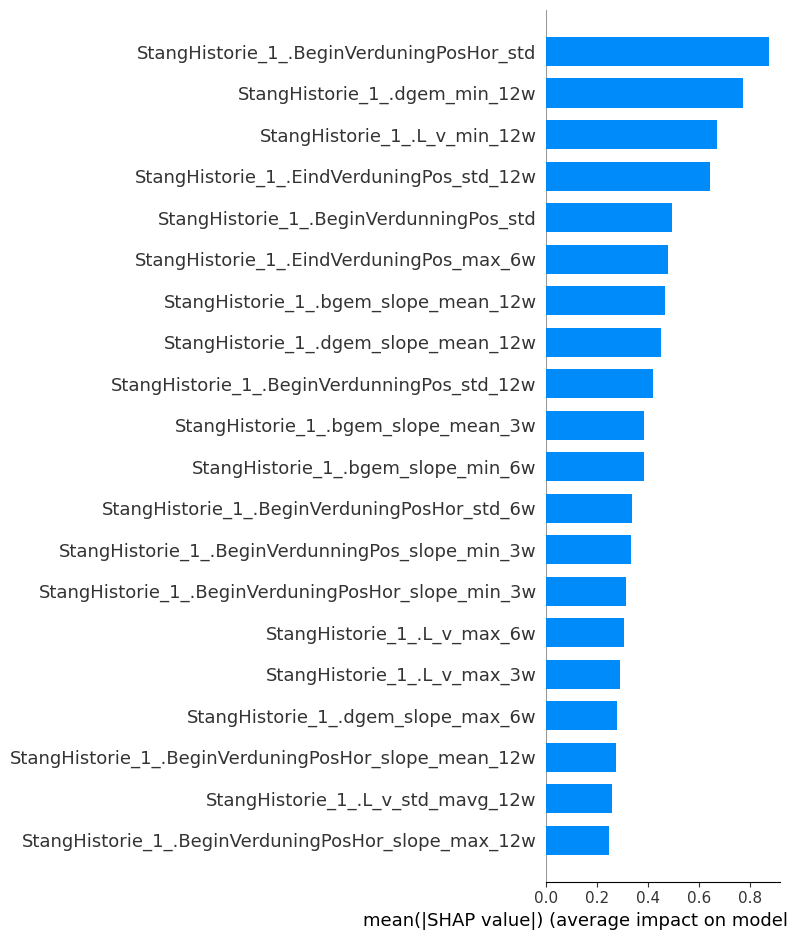

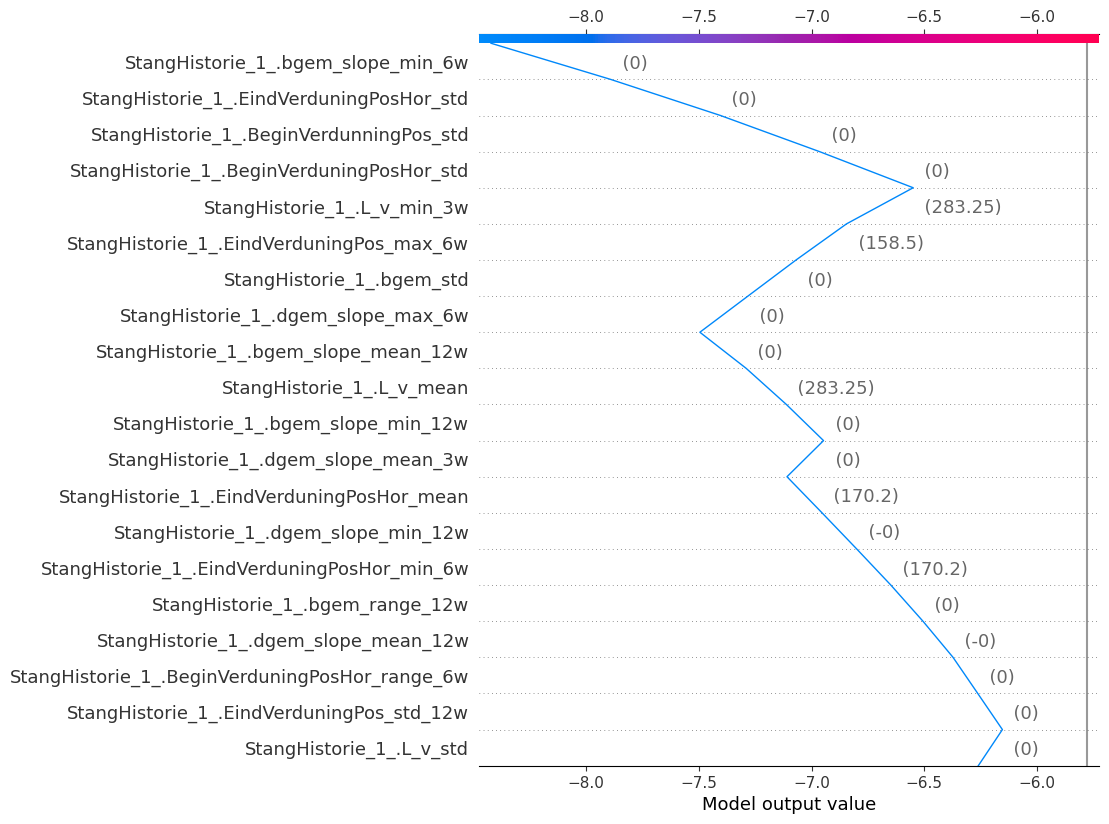

In [ ]:
explainer_clf = shap.TreeExplainer(best_clf)
shap_values_clf = explainer_clf.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values_clf, X_test, plot_type="dot")

# Bar plot
shap.summary_plot(shap_values_clf, X_test, plot_type="bar")
i = 30
shap.force_plot(explainer_clf.expected_value, shap_values_clf[i], X_test.iloc[i])
